In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import  StandardScaler, QuantileTransformer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import optuna

In [ ]:
#loading the data
train_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tasks/first task/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing
### Exploratory Data Analysis and Feature Engineering

In [ ]:
#checking the shape of the data
train_df.shape

(891, 12)

In [ ]:
#checking for null/missing values
train_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


#### Ticket & Cabin & PassengerId

In [ ]:
#dropping column
df=train_df.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1)

In [ ]:
#removing records with null values
df=df.dropna()

#### Name

In [ ]:
#Creating a new feature('Title')
df["Title"] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

df.drop(['Name'], axis=1, inplace=True)

df["Title"].value_counts()

,count
Title,
Mr,398
Miss,145
Mrs,107
Master,36
Rev,6
Dr,6
Mlle,2
Major,2
Col,2


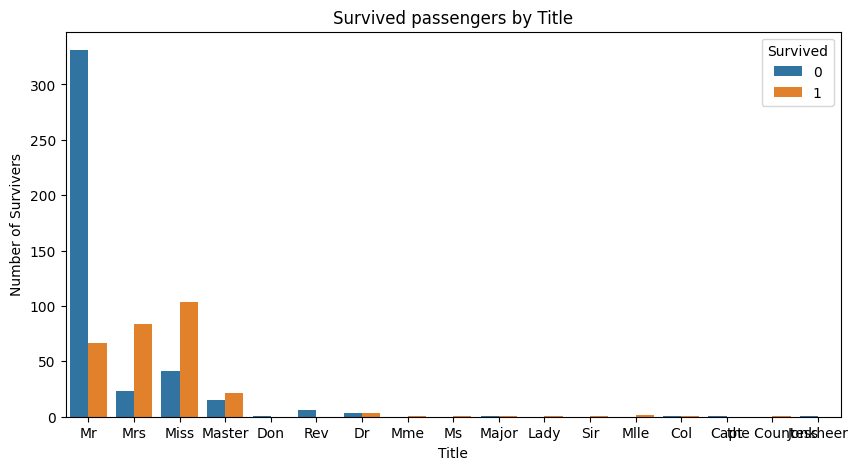

In [ ]:
#plotting number of survivors by title
plt.figure(figsize=(10, 5))
sns.countplot(x='Title', hue='Survived', data=df)
plt.title('Survived passengers by Title')
plt.xlabel('Title')
plt.ylabel('Number of Survivers')
plt.legend(title='Survived')
plt.show()

In [ ]:
#checking the survival percentage based on each title
title_survival_rate = df.groupby('Title')['Survived'].mean().sort_values()
title_survival_rate

,Survived
Title,
Capt,0.000000
Don,0.000000
Jonkheer,0.000000
Rev,0.000000
Mr,0.168342
Col,0.500000
Dr,0.500000
Major,0.500000
Master,0.583333


In [ ]:
#Creating a new feature('TitleCategory')
def map_title_by_survival(title):
    if title_survival_rate[title] > 0.5:
        return '2'
    elif 0.5 >= title_survival_rate[title] > 0.3:
        return '1'
    else:
        return '3'

df['TitleCategory'] = df['Title'].apply(map_title_by_survival)

df.drop(['Title'], axis=1, inplace=True)

df['TitleCategory']

,TitleCategory
0,3
1,2
2,2
3,2
4,3
...,...
885,2
886,3
887,2
889,3


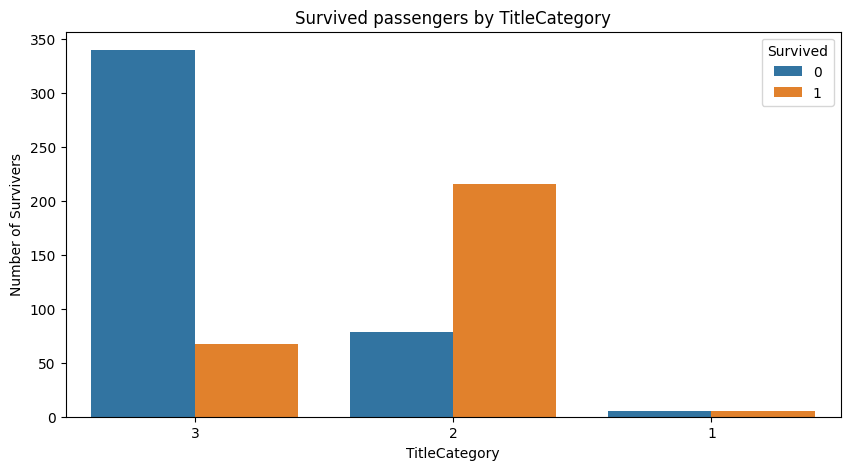

In [ ]:
#plotting number of survivors by titlecategory
plt.figure(figsize=(10, 5))
sns.countplot(x='TitleCategory', hue='Survived', data=df)
plt.title('Survived passengers by TitleCategory')
plt.xlabel('TitleCategory')
plt.ylabel('Number of Survivers')
plt.legend(title='Survived')
plt.show()

In [ ]:
# changing Pclass to object in order to apply one hot encoding to avoid ordinal relationship
df['Pclass']= df['Pclass'].astype('object')

In [ ]:
#encoding data using the get_dummies method
df_dummies=pd.get_dummies(df, drop_first=True)

In [ ]:
df_dummies.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,TitleCategory_2,TitleCategory_3
0,0,22.0,1,0,7.2500,False,True,True,False,True,False,True
1,1,38.0,1,0,71.2833,False,False,False,False,False,True,False
2,1,26.0,0,0,7.9250,False,True,False,False,True,True,False
3,1,35.0,1,0,53.1000,False,False,False,False,True,True,False
4,0,35.0,0,0,8.0500,False,True,True,False,True,False,True


In [ ]:
#Creating a new feature('AdultMale')
df_dummies['AdultMale']= ((df_dummies['Age']>=18) & (df_dummies['Sex_male'] == True))
df_dummies.groupby('Survived')['AdultMale'].sum()

,AdultMale
Survived,
0,325
1,70


In [ ]:
#checking the correlation of the adult male with survived
df_dummies['AdultMale'].corr(df_dummies['Survived'])

-0.5169272362545958

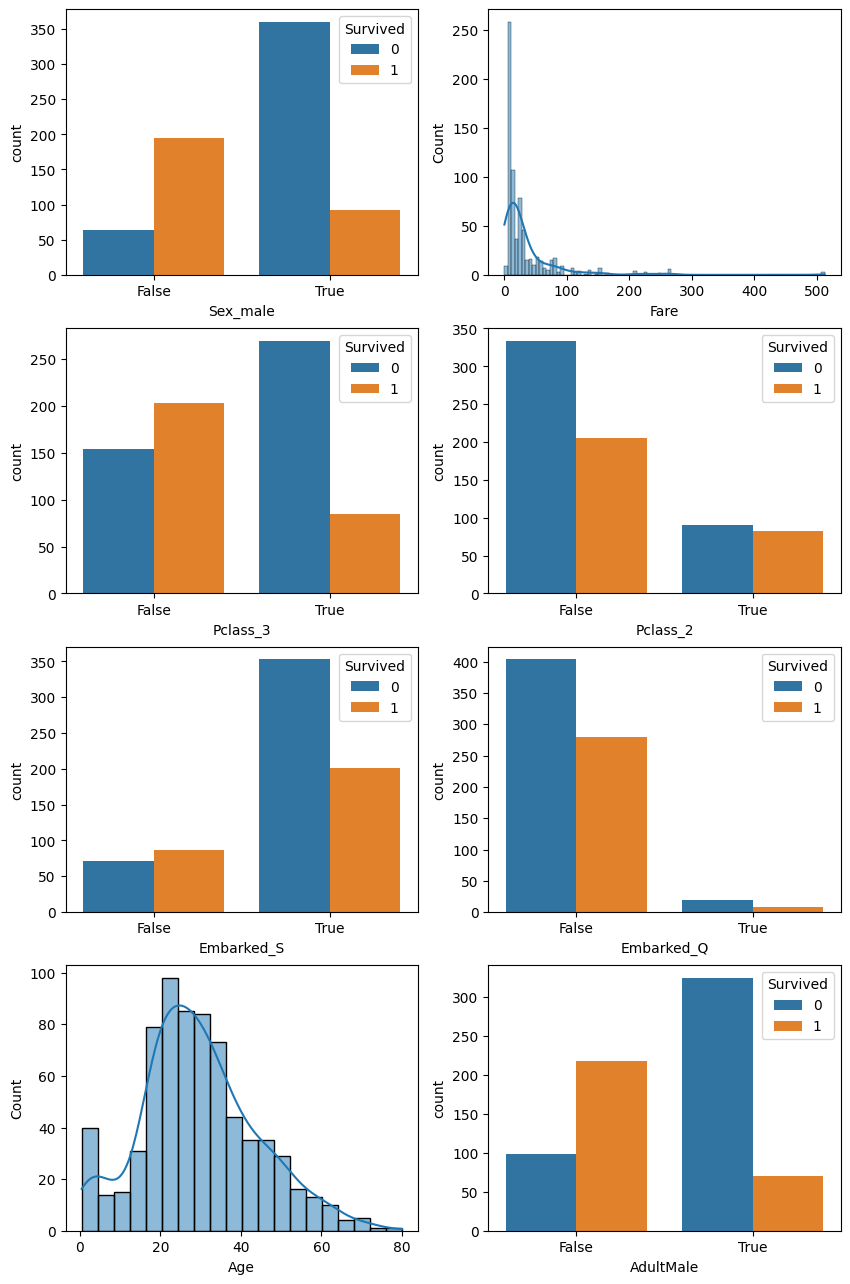

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(5,2,1)
sns.countplot(x= df_dummies['Sex_male'], hue="Survived", data=df_dummies)
plt.subplot(5,2,2)
sns.histplot(df_dummies['Fare'], kde=True)
plt.subplot(5,2,3)
sns.countplot(x= df_dummies['Pclass_3'], hue="Survived", data=df_dummies)
plt.subplot(5,2,4)
sns.countplot(x= df_dummies['Pclass_2'], hue="Survived", data=df_dummies)
plt.subplot(5,2,5)
sns.countplot(x= df_dummies['Embarked_S'], hue="Survived", data=df_dummies)
plt.subplot(5,2,6)
sns.countplot(x= df_dummies['Embarked_Q'], hue="Survived", data=df_dummies)
plt.subplot(5,2,7)
sns.histplot(df_dummies['Age'], kde=True)
plt.subplot(5,2,8)
sns.countplot(x= df_dummies['AdultMale'], hue="Survived", data=df_dummies)
plt.show()

#### Age & Fare

In [ ]:
#checking the skewness of age
df_dummies['Age'].skew()

0.38888061787537076

In [ ]:
#checking the Correlation of Age with other features
print("Correlation of Age with other features:")
df_dummies.corr()['Age']

Correlation of Age with other features:


,Age
Survived,-0.082446
Age,1.000000
SibSp,-0.307351
Parch,-0.187896
Fare,0.093143
Pclass_2,0.009214
Pclass_3,-0.309944
Sex_male,0.099037
Embarked_Q,-0.021693
Embarked_S,-0.025431


<Axes: ylabel='Age'>

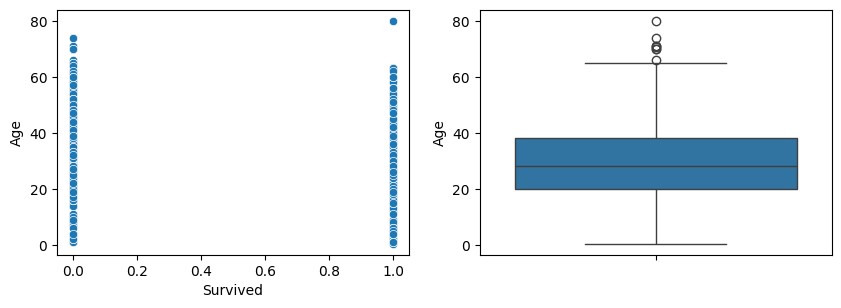

In [ ]:
#plotting graphs to check for missing values of age
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
sns.scatterplot(x= 'Survived', y= 'Age', data= df_dummies)
plt.subplot(2,2,2)
sns.boxplot(df_dummies['Age'])

<Axes: ylabel='Fare'>

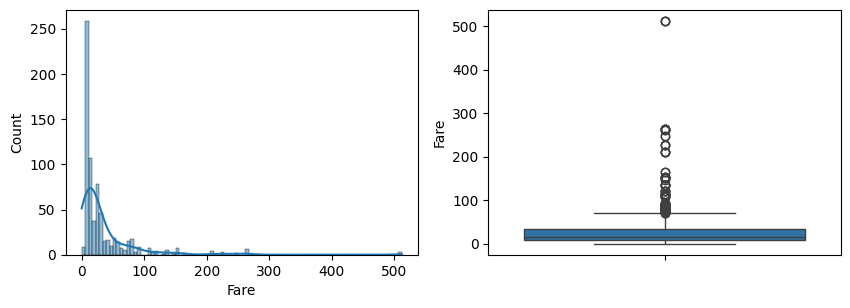

In [ ]:
#plotting graphs to check for missing values of fare
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
sns.histplot(df_dummies['Fare'], kde=True)
plt.subplot(2,2,2)
sns.boxplot(df_dummies['Fare'])

In [ ]:
#Replacing missing values and outliers using the QuantileTransformer to reduce skewness of continuous variables
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
df_dummies[['Age', 'Fare']] = quantile_transformer.fit_transform(df_dummies[['Age', 'Fare']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (712). n_quantiles is set to n_samples.
  warnings.warn(


skewness of fare= -0.44632672322859723
skewness of age= -0.0017781231267652625


<Axes: ylabel='Age'>

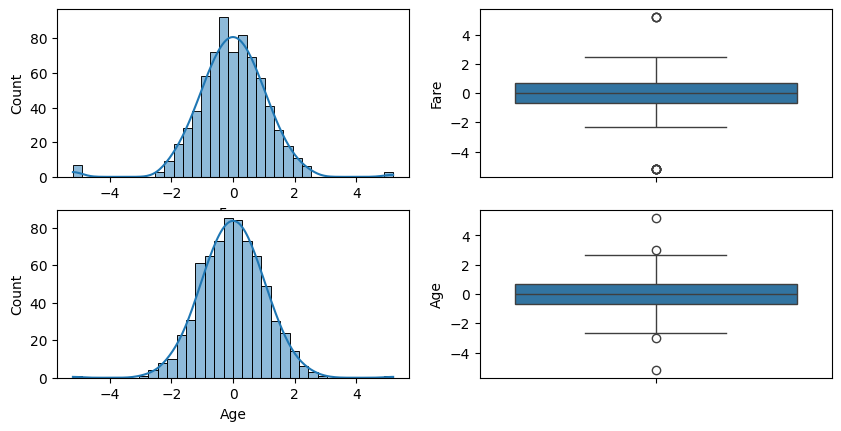

In [ ]:
print('skewness of fare=', df_dummies['Fare'].skew())
plt.figure(figsize=(10, 10))
plt.subplot(4,2,1)
sns.histplot(df_dummies['Fare'], kde=True)
plt.subplot(4,2,2)
sns.boxplot(df_dummies['Fare'])
print('skewness of age=',df_dummies['Age'].skew())
plt.subplot(4,2,3)
sns.histplot(df_dummies['Age'], kde=True)
plt.subplot(4,2,4)
sns.boxplot(df_dummies['Age'])

In [ ]:
#using IQR to reduce skewness
Q1 = df_dummies['Age'].quantile(0.25)
Q3 = df_dummies['Age'].quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df_dummies[(df_dummies['Age'] >= Q1 - 1.5 * IQR) & (df_dummies['Age'] <= Q3 + 1.5 * IQR)]

-0.002267000876458499


<Axes: ylabel='Age'>

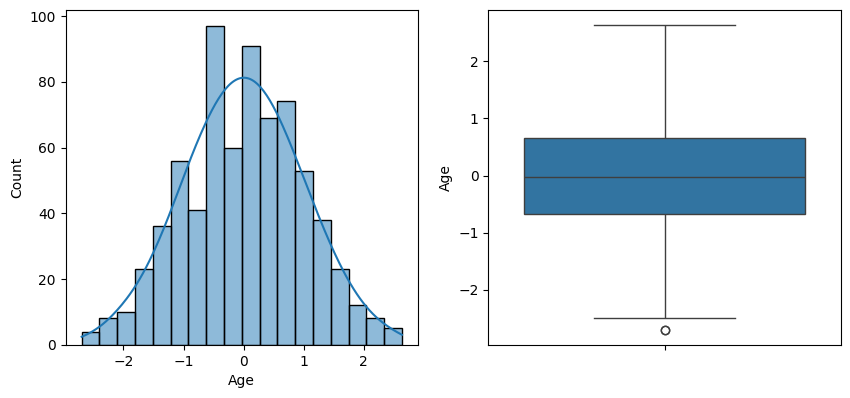

In [ ]:
plt.figure(figsize=(10, 20))
print(df_no_outliers['Age'].skew())
plt.subplot(4,2,3)
sns.histplot(df_no_outliers['Age'], kde=True)
plt.subplot(4,2,4)
sns.boxplot(df_no_outliers['Age'])

In [ ]:
#final normalizing for continuous variables
numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
scaler = StandardScaler()
df_dummies[numeric_features] = scaler.fit_transform(df_dummies[numeric_features])

In [ ]:
#descriptive statistics
df_dummies.describe().round(2)

,Survived,Age,SibSp,Parch,Fare
count,712.00,712.00,712.00,712.00,712.00
mean,0.40,0.00,-0.00,0.00,0.00
std,0.49,1.00,1.00,1.00,1.00
min,0.00,-5.06,-0.55,-0.51,-4.59
25%,0.00,-0.69,-0.55,-0.51,-0.59
50%,0.00,-0.02,-0.55,-0.51,0.01
75%,1.00,0.65,0.52,0.66,0.61
max,1.00,5.06,4.82,6.52,4.61


In [ ]:
df_dummies.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,TitleCategory_2,TitleCategory_3,AdultMale
0,0,-0.497235,0.522511,-0.506787,-1.285255,False,True,True,False,True,False,True,True
1,1,0.645386,0.522511,-0.506787,1.012595,False,False,False,False,False,True,False,False
2,1,-0.159644,-0.552714,-0.506787,-0.690404,False,True,False,False,True,True,False,False
3,1,0.469419,0.522511,-0.506787,0.852161,False,False,False,False,True,True,False,False
4,0,0.469419,-0.552714,-0.506787,-0.591944,False,True,True,False,True,False,True,True


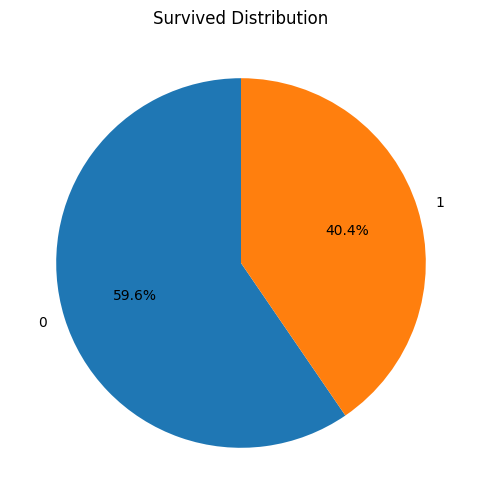

In [ ]:
#pie chart
plt.figure(figsize=(10,6))
plt.pie(df['Survived'].value_counts(), labels=[0, 1], autopct='%1.1f%%', startangle=90)
plt.title('Survived Distribution')
plt.show()

## Coorelation

<Axes: >

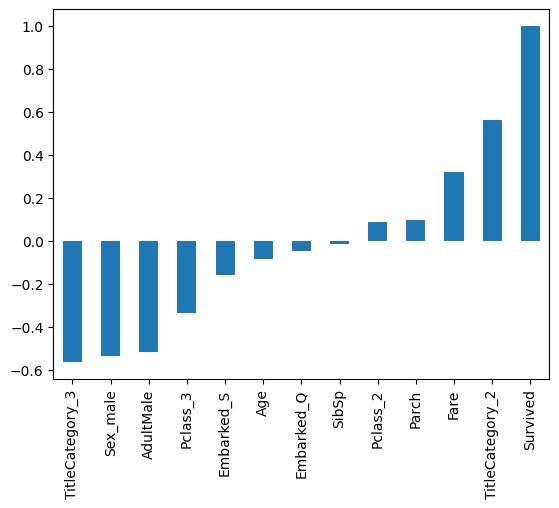

In [ ]:
df_dummies.corr()['Survived'].sort_values().plot(kind='bar')

<Axes: >

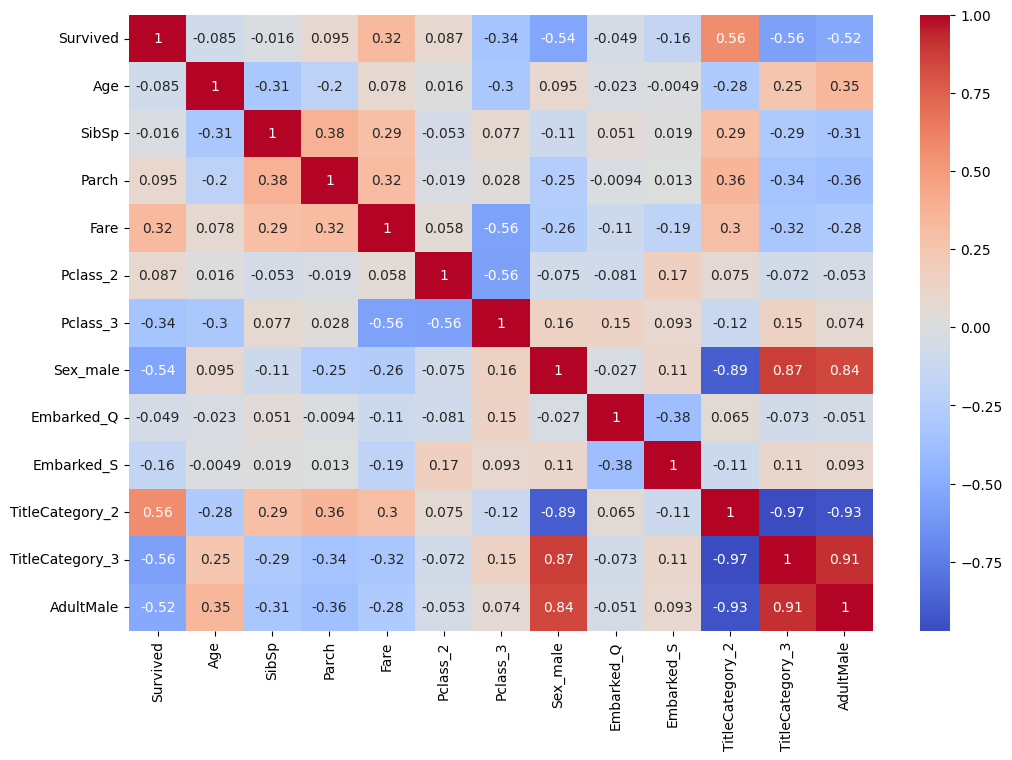

In [ ]:
#coorelation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_dummies.corr(),annot=True, cmap='coolwarm')

## Train Test Split

In [ ]:
X=df_dummies.drop(['Survived'], axis=1)
y=df_dummies['Survived']
Xtrain, Xtest, ytrain, ytest= train_test_split(X, y, test_size=0.3, random_state=13)

### Hypertuning the model

#### RandomForestClassifier

In [ ]:
# Optuna optimization function for Random Forest
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_int('max_features', 2, Xtrain.shape[1]),
    }
    model = RandomForestClassifier(**params, random_state=13)
    scores = cross_val_score(model, Xtrain, ytrain, cv=5, scoring='accuracy')
    return np.mean(scores)


In [ ]:
# Set Optuna logging level to show only warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
# Run Optuna optimization for Random Forest
study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=8))
study_rf.optimize(objective_rf, n_trials=30)

best_rf_params = study_rf.best_params
best_rf_model = RandomForestClassifier(**best_rf_params, random_state=13)
best_rf_model.fit(Xtrain, ytrain)
ypred_rf = best_rf_model.predict(Xtest)

print("Random Forest Best Params:", best_rf_params)
print("Random Forest Test Accuracy:", accuracy_score(ytest, ypred_rf))
print("Random Forest Train Accuracy:", accuracy_score(ytrain, best_rf_model.predict(Xtrain)))
print(classification_report(ytest, ypred_rf))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_rf))

Random Forest Best Params: {'n_estimators': 34, 'max_depth': 17, 'min_samples_split': 13, 'max_features': 3}
Random Forest Test Accuracy: 0.8878504672897196
Random Forest Train Accuracy: 0.8815261044176707
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       129
           1       0.89      0.82      0.85        85

    accuracy                           0.89       214
   macro avg       0.89      0.88      0.88       214
weighted avg       0.89      0.89      0.89       214

Confusion Matrix:
 [[120   9]
 [ 15  70]]


#### XGBClassifier

In [ ]:
# Optuna optimization function for XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    }
    model = XGBClassifier(**params, random_state=13, eval_metric='logloss')
    scores = cross_val_score(model, Xtrain, ytrain, cv=5, scoring='accuracy')
    return np.mean(scores)

In [ ]:
# Run Optuna optimization for XGBoost
study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=18))
study_xgb.optimize(objective_xgb, n_trials=30)

best_xgb_params = study_xgb.best_params
best_xgb_model = XGBClassifier(**best_xgb_params, random_state=13, eval_metric='logloss')
best_xgb_model.fit(Xtrain, ytrain)
ypred_xgb = best_xgb_model.predict(Xtest)

print("XGBoost Best Params:", best_xgb_params)
print("XGBoost Test Accuracy:", accuracy_score(ytest, ypred_xgb))
print("XGBoost Train Accuracy:", accuracy_score(ytrain, best_xgb_model.predict(Xtrain)))
print(classification_report(ytest, ypred_xgb))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_xgb))

XGBoost Best Params: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.038389342623478234, 'subsample': 0.9234637129813692, 'reg_alpha': 2.8646590710104474}
XGBoost Test Accuracy: 0.897196261682243
XGBoost Train Accuracy: 0.8534136546184738
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       129
           1       0.89      0.85      0.87        85

    accuracy                           0.90       214
   macro avg       0.90      0.89      0.89       214
weighted avg       0.90      0.90      0.90       214

Confusion Matrix:
 [[120   9]
 [ 13  72]]


#### LogisticRegression

In [ ]:
# Optuna optimization function for LogisticRegression
def objective_logreg(trial):
    C = trial.suggest_float('C', 1e-5, 100, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 5000)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    tol = trial.suggest_int('tol', 0.00001, 0.01)

    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, penalty=penalty, random_state=13)
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    accuracy = accuracy_score(ytest, y_pred)
    return accuracy

In [ ]:
# Run Optuna optimization for LogisticRegression
study_logreg = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=18))
study_logreg.optimize(objective_logreg, n_trials=100)

best_logreg_model = LogisticRegression(C=study_logreg.best_trial.params['C'], max_iter=study_logreg.best_trial.params['max_iter']
                                        , solver=study_logreg.best_trial.params['solver'], penalty=study_logreg.best_trial.params['penalty'])
best_logreg_model.fit(Xtrain, ytrain)
y_pred_logreg = best_logreg_model.predict(Xtest)

print(f"Best params: {study_logreg.best_trial.params}")
print("Logistic Regression test Accuracy:", accuracy_score(ytest, y_pred_logreg))
print("Logistic Regression Train Accuracy:", accuracy_score(ytrain, best_logreg_model.predict(Xtrain)))
print(classification_report(ytest, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_logreg))

Best params: {'C': 0.4599511111853513, 'max_iter': 4941, 'solver': 'liblinear', 'penalty': 'l1', 'tol': 0}
Logistic Regression test Accuracy: 0.8738317757009346
Logistic Regression Train Accuracy: 0.8072289156626506
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       129
           1       0.85      0.82      0.84        85

    accuracy                           0.87       214
   macro avg       0.87      0.87      0.87       214
weighted avg       0.87      0.87      0.87       214

Confusion Matrix:
 [[117  12]
 [ 15  70]]


#### DecisionTreeClassifier

In [ ]:
# Optuna optimization function for DecisionTreeClassifier
def objective_dtree(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, criterion=criterion, random_state=42)
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    accuracy = accuracy_score(ytest, y_pred)
    return accuracy

In [ ]:
# Run Optuna optimization for DecisionTreeClassifier
study_dtree = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=18))
study_dtree.optimize(objective_dtree, n_trials=100)

best_max_depth = study_dtree.best_trial.params['max_depth']
best_min_samples_split = study_dtree.best_trial.params['min_samples_split']
best_min_samples_leaf = study_dtree.best_trial.params['min_samples_leaf']
best_criterion = study_dtree.best_trial.params['criterion']

best_dtree_model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split,
                                           min_samples_leaf=best_min_samples_leaf, criterion=best_criterion, random_state=42)

best_dtree_model.fit(Xtrain, ytrain)
y_pred_dtree = best_dtree_model.predict(Xtest)

print(f"Best params: {study_dtree.best_trial.params}")
print("Decision Tree test Accuracy:", accuracy_score(ytest, y_pred_dtree))
print("Decision Tree Train Accuracy:", accuracy_score(ytrain, best_dtree_model.predict(Xtrain)))
print(classification_report(ytest, y_pred_dtree))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred_dtree))

Best params: {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'gini'}
Decision Tree test Accuracy: 0.8925233644859814
Decision Tree Train Accuracy: 0.8493975903614458
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       129
           1       0.93      0.79      0.85        85

    accuracy                           0.89       214
   macro avg       0.90      0.87      0.88       214
weighted avg       0.90      0.89      0.89       214

Confusion Matrix:
 [[124   5]
 [ 18  67]]


### StackingClassifier

In [ ]:
#Using Optuna to optimize hyperparameters for all models simultaneously and using them in a stacking model.
def objective(trial):
    # Parameters of base models
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 30, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
    rf_max_features = trial.suggest_int('rf_max_features', 2, Xtrain.shape[1])

    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 400)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 20)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3)
    xgb_subsample = trial.suggest_float('xgb_subsample', 0.6, 1.0)
    xgb_reg_alpha = trial.suggest_float('xgb_reg_alpha', 0, 10)

    dtree_max_depth = trial.suggest_int('dtree_max_depth', 2, 20)
    dtree_min_samples_split = trial.suggest_int('dtree_min_samples_split', 2, 10)
    dtree_min_samples_leaf = trial.suggest_int('dtree_min_samples_leaf', 1, 10)
    dtree_criterion = trial.suggest_categorical('dtree_criterion', ['gini', 'entropy'])

    # Parameters of meta model
    meta_C = trial.suggest_float('meta_C', 1e-5, 100, log=True)
    meta_max_iter = trial.suggest_int('meta_max_iter', 50, 400)
    meta_solver = trial.suggest_categorical('meta_solver', ['liblinear', 'saga'])
    meta_penalty = trial.suggest_categorical('meta_penalty', ['l2', 'l1'])

    # Definition of base models
    rf_model = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth,min_samples_split=rf_min_samples_split,
                                      max_features=rf_max_features, random_state=42)
    xgb_model = XGBClassifier(n_estimators=xgb_n_estimators, learning_rate=xgb_learning_rate, max_depth=xgb_max_depth,
                           subsample=xgb_subsample, reg_alpha=xgb_reg_alpha, random_state=42)
    dtree_model = DecisionTreeClassifier(max_depth=dtree_max_depth,min_samples_split=dtree_min_samples_split,
                                      min_samples_leaf=dtree_min_samples_leaf,criterion=dtree_criterion, random_state=42)

    # Definition of meta model
    meta_model = LogisticRegression(C=meta_C, solver=meta_solver,penalty=meta_penalty,max_iter=meta_max_iter,tol=0.00001, random_state=42)

    # Building the stacking model
    stack_model = StackingClassifier(
        estimators=[
            ('rf', rf_model),
            ('xgb', xgb_model),
            ('dtree', dtree_model)
        ],
        final_estimator=meta_model,
        cv=5
    )

    stack_model.fit(Xtrain, ytrain)

    y_pred_stacking = stack_model.predict(Xtest)
    return accuracy_score(ytest, y_pred_stacking)

In [ ]:
# Running Optuna.
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)

Best Parameters: {'rf_n_estimators': 281, 'rf_max_depth': 5, 'rf_min_samples_split': 5, 'rf_max_features': 11, 'xgb_n_estimators': 368, 'xgb_max_depth': 18, 'xgb_learning_rate': 0.05659048427045745, 'xgb_subsample': 0.9344553857565533, 'xgb_reg_alpha': 4.597612678519871, 'dtree_max_depth': 2, 'dtree_min_samples_split': 5, 'dtree_min_samples_leaf': 2, 'dtree_criterion': 'gini', 'meta_C': 14.873582512458205, 'meta_max_iter': 373, 'meta_solver': 'saga', 'meta_penalty': 'l1'}


In [ ]:
# Rebuilding base models
best_rf_model = RandomForestClassifier(
    n_estimators=study.best_params['rf_n_estimators'],
    max_depth=study.best_params['rf_max_depth'],
    min_samples_split=study.best_params['rf_min_samples_split'],
    max_features=study.best_params['rf_max_features'],
    random_state=42
)

best_xgb_model = XGBClassifier(
    learning_rate=study.best_params['xgb_learning_rate'],
    max_depth=study.best_params['xgb_max_depth'],
    n_estimators=study.best_params['xgb_n_estimators'],
    subsample=study.best_params['xgb_subsample'],
    reg_alpha=study.best_params['xgb_reg_alpha'],
    random_state=42
)

best_dtree_model = DecisionTreeClassifier(
    max_depth=study.best_params['dtree_max_depth'],
    min_samples_split=study.best_params['dtree_min_samples_split'],
    min_samples_leaf=study.best_params['dtree_min_samples_leaf'],
    criterion=study.best_params['dtree_criterion'],
    random_state=42
)

# Rebuilding meta model
best_meta_model = LogisticRegression(
    C=study.best_params['meta_C'],
    solver=study.best_params['meta_solver'],
    max_iter=study.best_params['meta_max_iter'],
    penalty=study.best_params['meta_penalty'],
    tol=0.0001,
    random_state=42
)

#Building final stacking model
best_stack_model = StackingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('xgb', best_xgb_model),
        ('dt', best_dtree_model)
    ],
    final_estimator=best_meta_model,
    cv=5
)

best_stack_model.fit(Xtrain, ytrain)
y_pred_stacking = best_stack_model.predict(Xtest)
print("stacking test Accuracy:", accuracy_score(ytest, y_pred_stacking))
print("stacking Train Accuracy:", accuracy_score(ytrain, best_stack_model.predict(Xtrain)))

stacking test Accuracy: 0.9018691588785047
stacking Train Accuracy: 0.857429718875502


#### Classification Report

In [ ]:
print(classification_report(ytest, y_pred_stacking))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       129
           1       0.92      0.82      0.87        85

    accuracy                           0.90       214
   macro avg       0.91      0.89      0.90       214
weighted avg       0.90      0.90      0.90       214



#### Confusion Matrix Heatmap

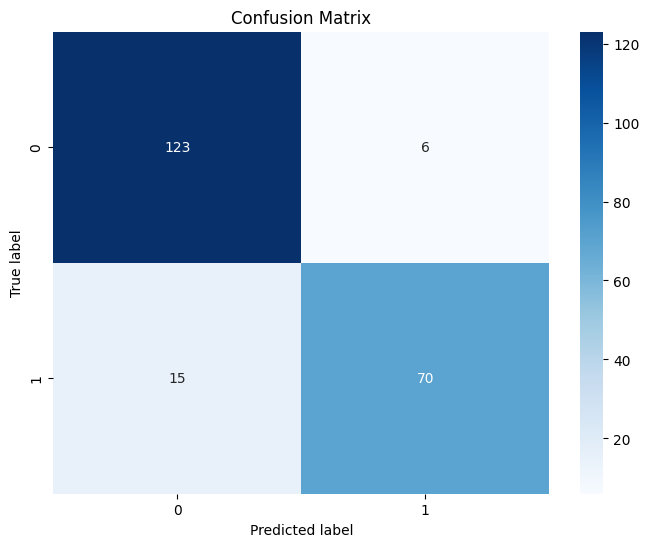

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ytest, y_pred_stacking), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()